In [1]:
import os.path as osp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn.inits import uniform
from torch.nn import Parameter as Param
from torch import Tensor 
torch.manual_seed(42)
from torch_geometric.nn.conv import MessagePassing, GatedGraphConv
from torch_geometric.nn import global_mean_pool,Linear, global_max_pool, global_add_pool,global_sort_pool
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np
from torch_geometric.utils import to_networkx
import os.path as osp
from math import ceil
import torch_geometric.transforms as T
from torch_geometric.nn import DenseGCNConv as GCNConv, dense_diff_pool,GATConv,SAGEConv,SAGPooling
import csv

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")      
else:
    device = torch.device("cpu")   
    

In [3]:
# dataset = TUDataset(root='data/TUDataset', name='PROTEINS_full')
# print()
# print(f'Dataset: {dataset}:')
# print('====================')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

# data = dataset[0]  # Get the first graph object.


In [4]:
def load(path, pickle_file, ratio=1):
    dataset = pd.read_pickle(path + pickle_file)
    dataset.info(memory_usage='deep')

    return dataset

def loads(data_sets_dir, ratio=1):
    data_sets_files = sorted([f for f in listdir(data_sets_dir) if isfile(join(data_sets_dir, f))])

    if ratio < 1:
        data_sets_files = get_ratio(data_sets_files, ratio)

    dataset = load(data_sets_dir, data_sets_files[0])
    data_sets_files.remove(data_sets_files[0])

    for ds_file in data_sets_files:
        dataset = dataset.append(load(data_sets_dir, ds_file))

    return dataset

In [5]:
input_dataset = loads("data/input/")
print(type(input_dataset))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21082 entries, 0 to 21081
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   21082 non-null  object
 1   target  21082 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 988.3 KB
<class 'pandas.core.frame.DataFrame'>


In [6]:
dataset = []
for r in input_dataset.iterrows():
    if r[1][0].num_nodes>10:
        dataset.append(r[1][0])
len(dataset)

    

14619

In [7]:
torch.manual_seed(12345)
random.shuffle(dataset)
train_ratio = 0.8
train_samples = int(len(dataset)*0.8)

train_dataset = dataset[:train_samples]
test_dataset = dataset[train_samples:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Number of training graphs: 11695
Number of test graphs: 2924


In [8]:
len(train_loader), device

(92, device(type='cuda', index=0))

In [9]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels,out_channels, num_layers,aggregator,num_features):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.ggc = GatedGraphConv(out_channels, num_layers,aggregator).to(device)
#         self.trconv = TransformerConv(out_channels, num_layers,aggregator).to(device)
        self.conv1 = GATConv(out_channels, hidden_channels, heads = 1).to(device)
#         self.conv2 = GCNConv(hidden_channels, int(hidden_channels/2)).to(device)
        self.conv2 = GATConv(hidden_channels, int(hidden_channels/2), heads = 1).to(device)
        self.conv3 = GATConv(int(hidden_channels/2), 16, heads = 1).to(device)
        self.lin = Linear(16, 2).to(device)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x_gcc = self.ggc(x, edge_index).to(device)
#         x_trcc = self.trconv(x, edge_index)
        hidden1 = self.conv1(x_gcc, edge_index).relu()
#         x = F.dropout(x, p=0.5, training=self.training)
        hidden2 = self.conv2(hidden1, edge_index).relu()
        hidden3 = self.conv3(hidden2, edge_index)
        x = global_max_pool(hidden3, batch) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x



In [10]:
hidden_channels = 64
out_channels = 200
num_layers = 3
aggregator = "add"
num_features = 200
# torch.cuda.empty_cache()
model = GNN(hidden_channels, out_channels, num_layers,aggregator,num_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x.to(device), data.edge_index.to(device), data.batch.to(device))  
        y = data.y.long()
        loss = criterion(out, y.to(device)) 
        loss.backward()  
        optimizer.step() 
        optimizer.zero_grad()
    return 

def test(loader):
    model.eval()
    correct = 0
    losses = []
    for data in loader:  
        out = model(data.x.to(device), data.edge_index.to(device), data.batch.to(device)) 
        y = data.y.long()
        loss = criterion(out, y.to(device)) 
        losses.append(loss.item())
        pred = out.argmax(dim=1)  
        correct += int((pred == data.y.to(device)).sum())  
    return correct / len(loader.dataset), np.mean(losses)

train_, test_, train_loss, test_loss = [],[],[],[]
max_train= max_test = 0
patience = 0
for epoch in range(1, 100):
    train()
    train_acc, t_loss = test(train_loader)
    test_acc,tst_loss = test(test_loader)
    train_.append(train_acc)
    test_.append(test_acc)
    train_loss.append(t_loss)
    test_loss.append(tst_loss)
    if test_acc>max_test:
        max_test = test_acc
        max_train = train_acc
        patience = 0
    else:
        patience +=1
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    if patience ==100:
        break
print("Final training accuracy: {}, test accuracy: {}".format(max_train,max_test))

Epoch: 001, Train Acc: 0.5645, Test Acc: 0.5773
Epoch: 002, Train Acc: 0.5829, Test Acc: 0.5910
Epoch: 003, Train Acc: 0.5645, Test Acc: 0.5773
Epoch: 004, Train Acc: 0.5936, Test Acc: 0.6067
Epoch: 005, Train Acc: 0.5797, Test Acc: 0.5776
Epoch: 006, Train Acc: 0.5903, Test Acc: 0.5876
Epoch: 007, Train Acc: 0.5801, Test Acc: 0.5923
Epoch: 008, Train Acc: 0.5930, Test Acc: 0.5886
Epoch: 009, Train Acc: 0.5741, Test Acc: 0.5934
Epoch: 010, Train Acc: 0.5864, Test Acc: 0.6005
Epoch: 011, Train Acc: 0.5973, Test Acc: 0.6026
Epoch: 012, Train Acc: 0.5960, Test Acc: 0.6115
Epoch: 013, Train Acc: 0.5974, Test Acc: 0.6043
Epoch: 014, Train Acc: 0.5972, Test Acc: 0.6077
Epoch: 015, Train Acc: 0.5921, Test Acc: 0.6057
Epoch: 016, Train Acc: 0.5989, Test Acc: 0.6091
Epoch: 017, Train Acc: 0.5976, Test Acc: 0.6053
Epoch: 018, Train Acc: 0.6007, Test Acc: 0.6118
Epoch: 019, Train Acc: 0.5984, Test Acc: 0.6036
Epoch: 020, Train Acc: 0.5979, Test Acc: 0.6067
Epoch: 021, Train Acc: 0.5929, Test Acc:

In [11]:
# gated_graph_conv_args = {"out_channels" : 200, "num_layers" : 3, "aggr" : "add", "bias": True}
# conv_args = {
#                 "conv1d_1" : {"in_channels": 205, "out_channels": 50, "kernel_size": 3, "padding" : 1},
#                 "conv1d_2" : {"in_channels": 50, "out_channels": 20, "kernel_size": 1, "padding" : 1},
#                 "maxpool1d_1" : {"kernel_size" : 3, "stride" : 2},
#                 "maxpool1d_2" : {"kernel_size" : 2, "stride" : 2}
#             }

# emb_size = 200
# model = GGNN(gated_graph_conv_args,conv_args,emb_size).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# # loss_fn = torch.nn.CrossEntropyLoss()
# loss_fn = torch.nn.BCEWithLogitsLoss()
# def train():
#     model.train()
#     for data in train_loader: 
# #         print(data.x.shape, data.y.shape)
#         prob = model(data.x.to(device), data.edge_index.to(device),data.batch.to(device)).to(device) 
#         y = data.y.type(torch.FloatTensor)  
#         loss = loss_fn(prob, y.to(device))  
#         loss.backward()  
#         optimizer.step() 
#         optimizer.zero_grad()
        
# def test(loader):
#     model.eval()
#     correct = 0
#     r = 0
#     for rounds, data in enumerate(loader):  
#         prob = model(data.x.to(device), data.edge_index.to(device),data.batch.to(device)).to(device)         
#         y = data.y.type(torch.FloatTensor).to(device)
#         acc = binary_acc(prob, y)
#         correct +=acc 
#         r = rounds
    
#     return correct/r

# train_, test_ = [],[]
# for epoch in range(100):
#     train()
#     train_acc = test(train_loader)
#     test_acc = test(test_loader)
#     train_.append(train_acc)
#     test_.append(test_acc)
#     print('Epoch: {:03d}, Train Acc: {:.5f},  Test Acc: {:.5f}'.format(epoch, train_acc,test_acc))
    

In [12]:
# l= []
# for d in test_dataset:
#     l.append(d.y)
# print(len(l), np.sum(l))

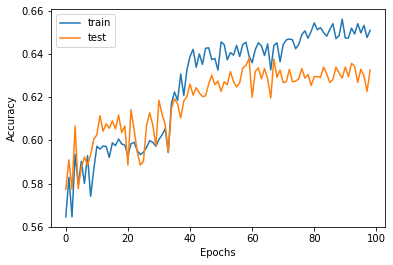

In [13]:
fig = plt.figure(figsize = (6,4))
plt.plot(train_, label ='train')
plt.plot(test_, label = 'test')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("results_new1.pdf")
plt.show()

In [14]:
# import csv
# file = open("results1.csv",'a',newline = '')
# res_writer = csv.writer(file, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
# res_writer.writerow(train_)
# res_writer.writerow(test_)
# file.flush()
# file.close()